In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

df = pd.read_csv("C:\\Users\\SITS\\Videos\\Git upload\\Quora eda\\train.csv").fillna("")
df.head() 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


So we have six columns in total one of which is the label.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [3]:
df.shape

(404290, 6)

We have a fairly balanced dataset here.

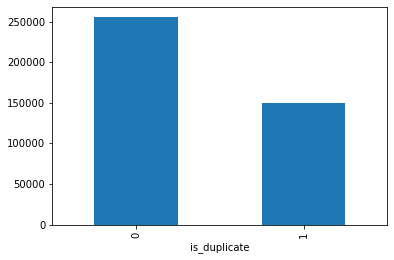

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

# Feature construction

We will now construct a basic set of features that we will later use to embed our samples with.

The first we will be looking at is rather standard TF-IDF encoding for each of the questions. In order to limit the computational complexity and storage requirements we will only encode the top terms across all documents with TF-IDF and also look at a subsample of the data.

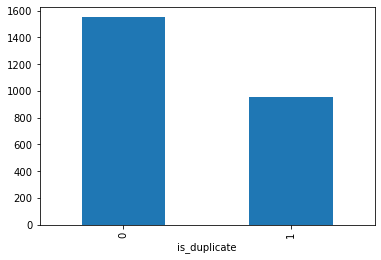

In [6]:
dfs = df[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

The subsample still has a very similar label distribution, ok to continue like that, without taking a deeper look how to achieve better sampling than just taking the first rows of the dataset.

Create a dataframe where the top 50% of rows have only question 1 and the bottom 50% have only question 2, same ordering per halve as in the original dataframe.

In [7]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

Transform questions by TF-IDF.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31364 stored elements in Compressed Sparse Row format>

Since we are looking at pairs of data, we will be taking the difference of all question one and question two pairs with this. This will result in a matrix that again has the same number of rows as the subsampled data and one vector that describes the relationship between the two questions.

In [9]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29264 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

We will use t-SNE to embed the TF-IDF vectors in three dimensions and create an interactive scatter plot with them.

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.608s...
[t-SNE] Computed neighbors for 2500 samples in 5.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466462
[t-SNE] Computed conditional probabilities in 0.439s
[t-SNE] Iteration 50: error = 120.0312195, gradient norm = 0.0454751 (50 iterations in 8.952s)
[t-SNE] Iteration 100: error = 130.1940765, gradient norm = 0.0467043 (50 iterations in 12.146s)
[t-SNE] Iteration 150: error = 133.6005096, gradient norm = 0.0561684 (50 iterations in 10.611s)
[t-SNE] Iteration 200: error = 135.0326080, gradient norm = 0.0338338 (50 iterations in 8.728s)
[t-SNE] Iteration 250: error = 133.2165833, gradient norm = 0.1399466 (50 iterations in 9.972s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 133.216583
[t-SNE] KL divergen

In [12]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

That three dimensional embedding looks nice, but is not telling us much about the structure of the space that we created. There seem to be no clusters of either class present, so let's go on to the next section.

## Feature EDA

Let us now construct a few features

* character length of questions 1 and 2
* number of words in question 1 and 2
* normalized word share count.

We can then have a look at how well each of these separate the two classes.

In [13]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


The distributions for normalized word share have some overlap on the far right hand side, meaning there are quite a lot of questions with high word similarity but are both duplicates and non-duplicates.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



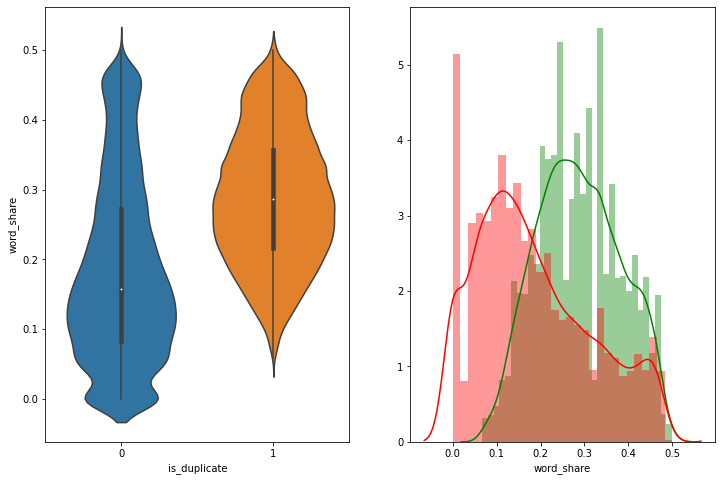

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

Scatter plot of question pair character lengths where color indicates duplicates and the size the word share coefficient we've calculated earlier.

In [15]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

What is interesting about that, is that as the number of words increases, the distribution of character lengths of the first and second question becomes less and less spherical.

# Embedding with engineered features

We will now revisit the t-SNE embedding with the manually engineered features.

For that we use the number of words in both questions, character lengths and their word share coefficient. t-SNE is sensitive to scaling of different dimensions and we want all of the dimensions to contribute equally to the distance measure that t-SNE is trying to preserve.

In [18]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:3000]
X = MinMaxScaler().fit_transform(df_subsampled[['q1_n_words', 'q1len', 'q2_n_words', 'q2len', 'word_share']])
y = df_subsampled['is_duplicate'].values

In [20]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.012s...
[t-SNE] Computed neighbors for 3000 samples in 0.287s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.034931
[t-SNE] Computed conditional probabilities in 0.499s
[t-SNE] Iteration 50: error = 75.4888153, gradient norm = 0.0364241 (50 iterations in 6.344s)
[t-SNE] Iteration 100: error = 68.1238937, gradient norm = 0.0028297 (50 iterations in 4.024s)
[t-SNE] Iteration 150: error = 67.6386948, gradient norm = 0.0008747 (50 iterations in 4.233s)
[t-SNE] Iteration 200: error = 67.5446777, gradient norm = 0.0005443 (50 iterations in 4.761s)
[t-SNE] Iteration 250: error = 67.5163727, gradient norm = 0.0002076 (50 iterations in 5.394s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.516373
[t-SNE] KL divergence after

In [21]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

The embedding of the engineered features has much more structure than the previous one where we were only computing differences of TF-IDF encodings.

In the cluster of the negatives we have few positives whereas in the cluster of positives we have a lot more negatives. That matches our observation from the boxplot of word share coefficient above, where we could see that the negative class has a lot of overlap with the positive class for high word share coefficients.

# Parallel Coordinates

We now want to get another perspective on high dimensional data, such as the TF-IDF encoded questions. For that purpose I'll encode the concatenated questions into a set of N dimensions, s.t. each row in the dataframe then has one N dimensional vector associated to it.
With this we can then have a look at how these coordinates (or TF-IDF dimensions) vary by label.

There are many EDA methods to visualize high dimensional data, I'll show parallel coordinates here.

To make a nice looking plot, I've chosen N to be quite small, much smaller actually than you would encode it in a machine learning algorithm.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'value of dimension')

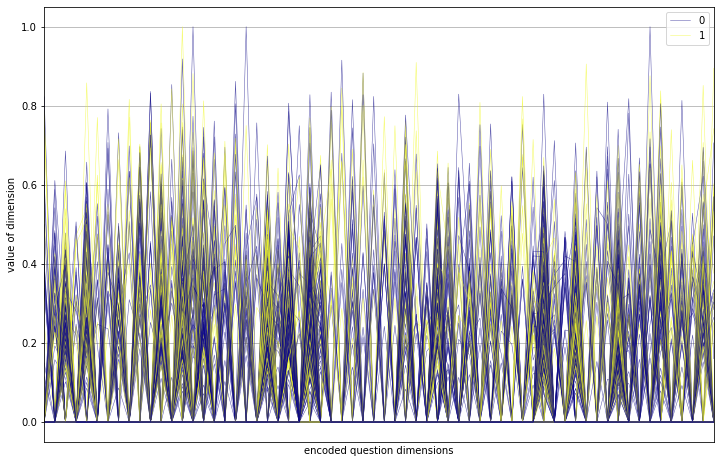

In [23]:
from pandas.plotting import parallel_coordinates

df_subsampled = df[0:500]

N = 64

#encoded = HashingVectorizer(n_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
encoded = TfidfVectorizer(max_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
# generate columns in the dataframe for each of the 32 dimensions
cols = ['hashed_'+str(i) for i in range(encoded.shape[1])]
for idx, col in enumerate(cols):
    df_subsampled[col] = encoded[:,idx].toarray()

plt.figure(figsize=(12,8))
kws = {
    'linewidth': 0.5,
    'alpha': 0.7
}
parallel_coordinates(
    df_subsampled[cols + ['is_duplicate']],
    'is_duplicate',
    axvlines=False, colormap=plt.get_cmap('plasma'),
    **kws
)
#plt.grid(False)
plt.xticks([])
plt.xlabel("encoded question dimensions")
plt.ylabel("value of dimension")

In the parallel coordinates we can see that there are some dimensions that have high TF-IDF features values for duplicates and others high values for non-duplicates.

# Question character length correlations by duplication label

The pairplot of character length of both questions by duplication label is showing us that, duplicated questions seem to have a somewhat similar amount of characters in them.

Also we can see something quite intuitive, that there is rather strong correlation in the number of words and the number of characters in a question.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in a

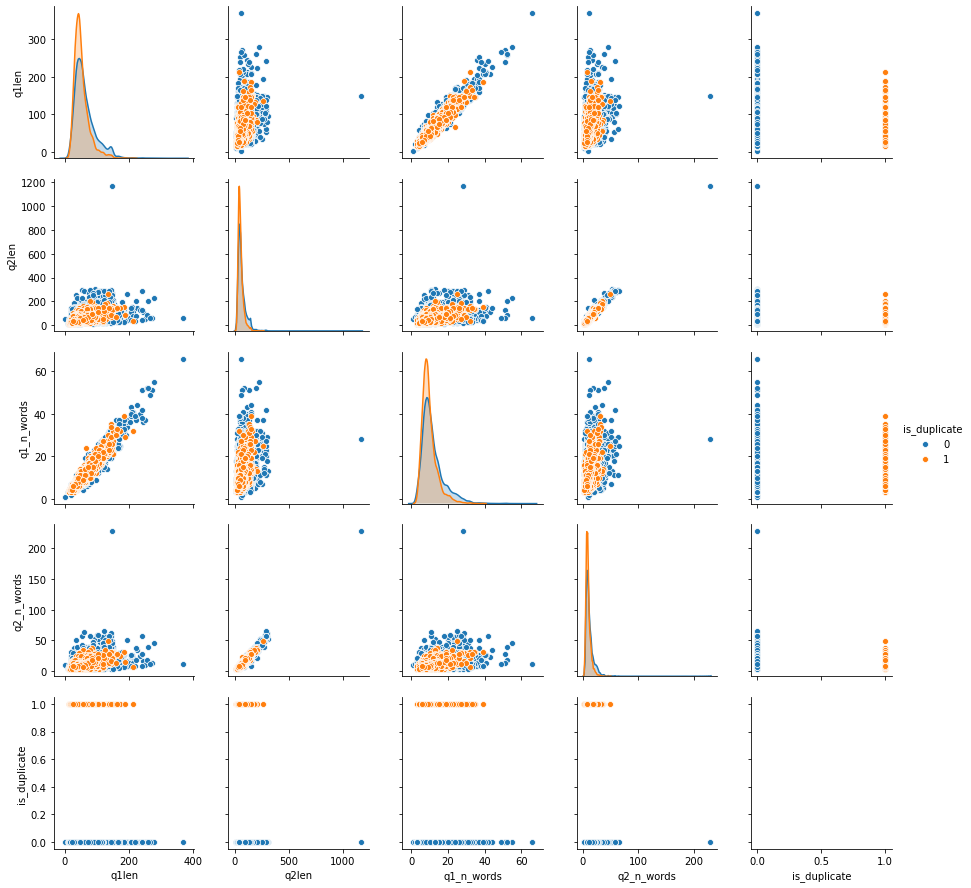

In [24]:
n = 10000
sns.pairplot(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

# Model starter

Train a model with the basic feature we've constructed so far.

For that we will use Logisitic regression, for which we will do a quick parameter search with CV, plot ROC and PR curve on the holdout set and finally generate a submission.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((270874, 5), (133416, 5), (270874,), (133416,))

Run cross-validation with a few hyper parameters.

In [26]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.4s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
             scoring='neg_log_loss', verbose=1)

Print validation results. Here we see that the strongly regularized model has much worse negative log loss than the other two models, regardless of which regularizer we've used.

In [27]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

4. Mean validation neg log loss: nan (std: nan) - {'C': 1e-06, 'penalty': 'l1'}
3. Mean validation neg log loss: -0.658 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
5. Mean validation neg log loss: nan (std: nan) - {'C': 0.001, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.582 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
6. Mean validation neg log loss: nan (std: nan) - {'C': 1.0, 'penalty': 'l1'}
1. Mean validation neg log loss: -0.568 (std: 0.002) - {'C': 1.0, 'penalty': 'l2'}


In [28]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l2'}
[[-10.25755613  -0.9265136    6.78974163  -7.16385701   3.29906896]]


### ROC

Receiver operator characteristic, used very commonly to assess the quality of models for binary classification.

We will look at at three different classifiers here, a strongly regularized one and two with weaker regularization. The heavily regularized model has parameters very close to zero and is actually worse than if we would pick the labels for our holdout samples randomly.

C: 1e-06, parameters [[-0.00106753 -0.00061358 -0.0008787  -0.00056285  0.01291754]] and intercept [-0.54411746]
C: 0.0001, parameters [[-0.09281881 -0.05367099 -0.07564567 -0.04894915  0.91607868]] and intercept [-0.9348591]
C: 1.0, parameters [[-10.25755613  -0.9265136    6.78974163  -7.16385701   3.29906896]] and intercept [-1.34038288]


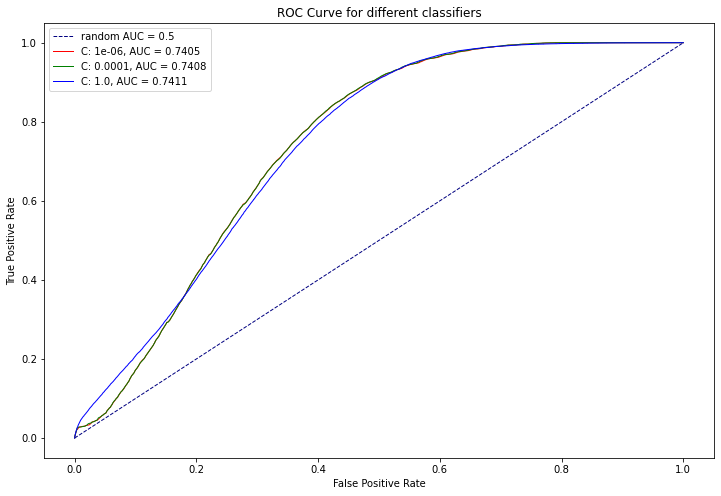

In [29]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

# Precision-Recall Curve

Also used very commonly, but more often in cases where we have class-imbalance. We can see here, that there are a few positive samples that we can identify quite reliably. On in the medium and high recall regions we see that there are also positives samples that are harder to separate from the negatives.

Text(0, 0.5, 'Precision')

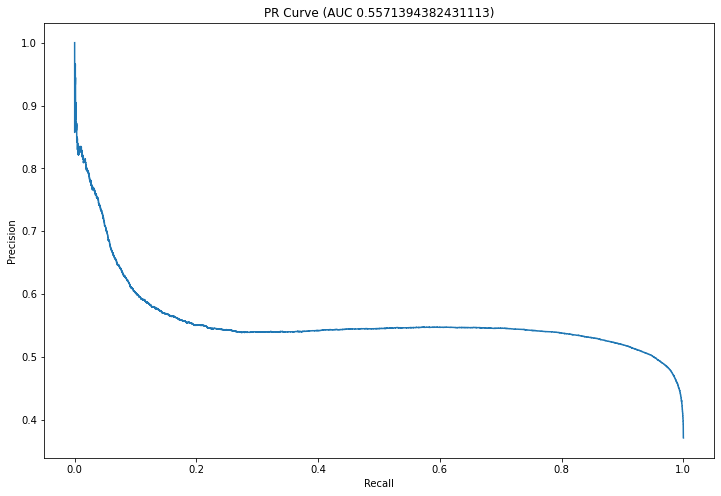

In [30]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

# Prepare submission

Here we read the test data and apply the same transformations that we've used for the training data. We also need to scale the computed features again.

In [31]:
dftest = pd.read_csv("C:\\Users\\SITS\\Videos\\Git upload\\Quora eda\\test.csv").fillna("")

dftest['q1len'] = dftest['question1'].str.len()
dftest['q2len'] = dftest['question2'].str.len()

dftest['q1_n_words'] = dftest['question1'].apply(lambda row: len(row.split(" ")))
dftest['q2_n_words'] = dftest['question2'].apply(lambda row: len(row.split(" ")))

dftest['word_share'] = dftest.apply(normalized_word_share, axis=1)

dftest.head()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,11,14,0.083333
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,66,43,14,7,0.190476
2,2,What but is the best way to send money from Ch...,What you send money to China?,60,29,14,6,0.222222
3,3,Which food not emulsifiers?,What foods fibre?,27,17,4,3,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,4,6,0.300000


We use the best estimator found by cross-validation and retrain it, using the best hyper parameters, on the whole training set.

In [32]:
retrained = cv.best_estimator_.fit(X, y)

X_submission = scaler.transform(dftest[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]

submission = pd.DataFrame({'test_id': dftest['test_id'], 'is_duplicate': y_submission})
submission.head()

,test_id,is_duplicate
0,0,0.164653
1,1,0.341177
2,2,0.423963
3,3,0.155515
4,4,0.521909


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



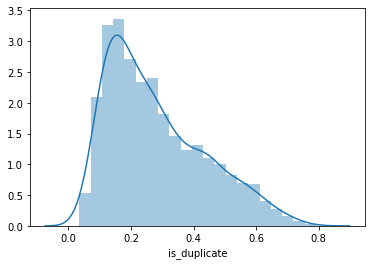

In [33]:
sns.distplot(submission.is_duplicate[0:2000])